In [2]:
from decimal import InvalidOperation
from sys import path
from numpy.core.numeric import cross
import pydicom as pyd
import numpy as np 
import matplotlib.pyplot as plt 
from PIL import Image 

# Problem 1 Sharpen Image 
Implemented using convolution. We opted to pad the image with zeros to make the operation valid 

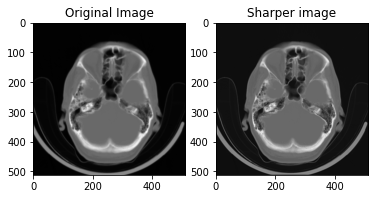

In [42]:


def pad_img(img,kernel,pad='zero'): 
    x,y = img.shape 
    #figure out by how much to extend image by 
    k_x,k_y = np.floor(kernel.shape[0]/2).astype(int),np.floor(kernel.shape[1]/2).astype(int)
    #copy over the values
    copy = np.zeros((x+k_x,y+k_y))
    for i in range(0,x):
        for j in range(0,y):
            copy[i+k_x,j+k_y] = img[i,j]
    copy[0:k_x,:] = copy[k_x,:]
    copy[-1*k_x:,:] = copy[-1*k_x,:]
    for e in range(0,k_y): 
        copy[:,e]= copy[:,k_y]
    for e in range(-1*k_y,-1):
        copy[:,e] = copy[:, e]
    #copy = np.pad(img,[k_x,k_y],mode='edge')
    return copy

def convolution(mat,k,pad='zero'): 
    kernel = k.T # required kernel flip 
    p_img = pad_img(mat,kernel=kernel,pad=pad) 
    dx,dy = kernel.shape
    k_x,k_y = np.floor(kernel.shape[0]/2).astype(int),np.floor(kernel.shape[1]/2).astype(int)
    out_img = np.zeros(p_img.shape)
    divisor =  np.sum(kernel[:]) 
    if divisor ==0:
        #on testing this value was usually zero. 
        #kept for consistency with class definiton
        divisor = 1 
    for i in range(k_x,p_img.shape[0]-k_x): 
        for j in range(k_y,p_img.shape[1]-k_y):
            #lazy trick is to do dot product
            flat_t = kernel.flatten() 
            flat_p_img = p_img[i-k_x:i-k_x+dx ,j-k_y:j-k_y+dy].flatten()
            out_img[i,j]= np.dot(flat_t , flat_p_img)/divisor
    # crop out the valid portions
    final_out = out_img[k_x:k_x+mat.shape[0]+1,k_y:k_y+mat.shape[1] +1 ]
    return final_out


#Image loading 
dcm = pyd.dcmread('./ID_0002a616e.dcm')
img = dcm.pixel_array  
#defining kernel of interest
kernel = np.array([[0,-1,0],[-1,5,-1],[0,-1,0]])
out = convolution(img, kernel) 
plt.figure(1)
plt.subplot(121)
plt.imshow(img,cmap='gray')
plt.title("Original Image")
plt.subplot(122)
plt.imshow(out,cmap='gray')
plt.title("Sharper image")
plt.show()


# Problem 2: Identifying dentricles. 
For this task we had to identify dentricles in a provided image.

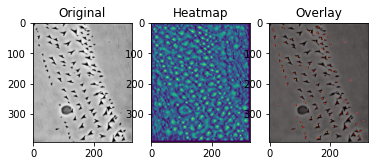

In [17]:
def cross_corr(mat,kernel,norm_input=False): 
    #traditional padding 
    p_img = pad_img(mat,kernel=kernel)
    #figure out dimensions  
    dx,dy = kernel.shape 
    k_x,k_y = np.floor(kernel.shape[0]/2).astype(int),np.floor(kernel.shape[1]/2).astype(int)
    out_img = np.zeros(p_img.shape)
    #iterate through the image
    for i in range(k_x,p_img.shape[0]-k_x): 
        for j in range(k_y,p_img.shape[1]-k_y):
            flat_t = kernel.flatten() 
            flat_p_img = p_img[i-k_x:i-k_x+dx ,j-k_y:j-k_y+dy].flatten()
            #normalize input to get -1 to 1 output 
            if norm_input: 
                flat_p_img = flat_p_img-np.mean(flat_p_img)
                flat_p_img = (flat_p_img )/np.linalg.norm(flat_p_img)
            #zero norm occurs when vector is zero. output is zero 
            if np.any( np.isnan(flat_p_img)):
                out_img[i,j]= 0 
            else:
                out_img[i,j]= np.dot(flat_t , flat_p_img) 
    #crop out the true output
    final_out = out_img[k_x:k_x+mat.shape[0]+1,k_y:k_y+mat.shape[1] +1 ]
    # plus one is due to range being [0,x) not inclusive
    return final_out
#this function is used to accumulate output probabilities
def swap_max(a,b):
    output = np.zeros(a.shape)
    for i in range(0,a.shape[0]):
        for j in range(0,a.shape[1]): 
            if  a[i,j]  >= b[i,j]:
                output[i,j] =  a[i,j]
            else: 
                output[i,j] = b[i,j]
    return output

#Image loading is mdae in grayscale form
main =  np.array(Image.open('main_img.png').convert(mode='L'))
out = np.zeros(main.shape)
#The dendricles vary in size/orientation. Using different bounding boxes 
#i settlered in this size range
for sizes in [(11,11),(13,13),(15,15),(17,17),(25,25),(27,27)]:
    temp = Image.open('Template.png').convert(mode='L').resize(sizes )
    for deg in [0,25,45,90,180,270]: 
        #template is always normalzied for -1 to 1 output
        template = np.array( temp.rotate(deg))
        template = template-np.mean(template)
        template = (template)/np.linalg.norm(template)
        out =  swap_max( out,cross_corr(main,template,norm_input=True) )
plt.figure()
plt.subplot(131)
plt.imshow(main,cmap='gray')
plt.title('Original')
plt.subplot(132)
mask = out > .75
plt.imshow(out)
plt.title('Heatmap')
plt.subplot(133)
plt.title('Labeled')
plt.imshow(main,cmap='gray') 
plt.imshow(mask,alpha=.5,cmap='hot')

# Problem 3: Apply Edge detection

Edge detection is done by applying the kernel [[-1,-1,-1],[-1,-8,-1],[-1,-1,-1]].  The output isn't ideal as there is  some artifat at the bototm edge of the image. This  would be an artifact of our inhouse zero padding technique. 

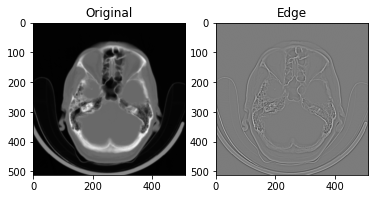

In [44]:
dcm = pyd.dcmread('./ID_0002a616e.dcm')
img = dcm.pixel_array  
kernel = np.array([[-1,-1,-1],[-1,8,-1],[-1,-1,-1]])
out =convolution(img, kernel,pad='same')
plt.figure(1)
plt.subplot(121)
plt.title("Original")
plt.imshow(img,cmap='gray')
plt.subplot(122)
plt.title("Edge detected")
plt.imshow( out ,cmap='gray')
plt.show()